# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 4 - RNN



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

<span style="color:red">**Model training can be very slow; start doing this HW early**</span>

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

<div class="theme"> Overview: Named Entity Recognition Challenge</div>

Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 

This represents an interesting "many-to-many" problem, allowing us to experiment with recurrent architectures and compare their performances against other models.


In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
plt.style.use("ggplot")


In [3]:
import keras
import tensorflow as tf

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical,np_utils
from keras import backend

from keras.models import Model, Input, Sequential,model_from_json
from keras.layers import SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                         Dropout, Bidirectional, Conv1D, BatchNormalization

print(keras.__version__)
print(tf.__version__)

Using TensorFlow backend.


2.2.4
1.13.1


In [4]:
# Set seed for repeatable results
np.random.seed(123)
tf.set_random_seed(456)

<div class='explication'> </div>


## Part 1: Read the data

Read in data ```HW4_data.csv``` and use the  code below to open the csv as a pandas dataframe.

As you can see, we have a dataset with sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. ```POS``` will not be used for this homework. We will predict ```Tag``` using only the words themselves.

Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity

In [5]:
# Given code
path_dataset = './data/HW4_data.csv'
data = pd.read_csv(path_dataset, encoding="latin1")
data = data.fillna(method="ffill")
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


<div class='exercise'><b> Question 1.  Prepare Data [20pt]</b></div>


<span class='sub-q'> **Question 1.1**</span> 
* (1) Create a list of unique words found in column 'Word'
* (2) Sort the list in alphabetic order
* (3) Append the special word "ENDPAD" to the end of the list, and store it to a variable ```words```
* (4) Store the length of this list to a variable ```n_words```

<div class='explication'> </div>

In [6]:
data.shape

(1048575, 4)

In [7]:
# your code #
# (1) Unique Words
words = list(data['Word'].unique())
# (2) Sort alphabetically
words.sort()
print('First ten items in the sorted list:\n%s'%words[:10])
# (3) Append 'ENDPAD'
words.append('ENDPAD')
display(words[-1:])
# (4) Length
n_words = len(words)
print('Number of unique words: %s'%n_words)

First ten items in the sorted list:
['!', '"', '#', '#NAME?', '$', '%', '%-plus', '&', "'", "'70s"]


['ENDPAD']

Number of unique words: 35179


<span class='sub-q'>**Question 1.2**</span>
* (1) Store a list of unique tags into a variable ```tags```, paying attention to sort the list in alphabetic order
* (2) Append the special tag "PAD" to the end of the list
* (3) Store the length of this list to a variable ```n_tags```

<div class='explication'> </div>

In [8]:
# your code #
# (1)
tags = list(data['Tag'].unique())
tags.sort()
print('First ten items in the sorted list:\n%s'%tags[:10])
# (2) Append 'PAD'
tags.append('PAD')
display(tags[-1:])
# (3) Length 
n_tags = len(tags)
print('Number of unique tags: %s'%n_tags)

First ten items in the sorted list:
['B-art', 'B-eve', 'B-geo', 'B-gpe', 'B-nat', 'B-org', 'B-per', 'B-tim', 'I-art', 'I-eve']


['PAD']

Number of unique tags: 18


<span class='sub-q'>**Question 1.3**</span>
* (1) Process data into a list of sentences, each sentence is a list of (word, tag) tuples.

**Example**

First sentence in the list of sentences:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
* (2) Find out the number of words in the longest sentence, and store it to variable ```max_len```


<div class='explication'> </div>

In [9]:
len(data['Sentence #'].unique())

47959

In [10]:
data['Word-Tag'] = list(zip(data['Word'], data['Tag']))
data['Word-Tag'].head(10)

0        (Thousands, O)
1               (of, O)
2    (demonstrators, O)
3             (have, O)
4          (marched, O)
5          (through, O)
6       (London, B-geo)
7               (to, O)
8          (protest, O)
9              (the, O)
Name: Word-Tag, dtype: object

In [11]:
# (1) Longest sentence length
data_gb = data.groupby(by='Sentence #')

In [12]:
word_tag_df = pd.DataFrame(data_gb['Word-Tag'].apply(lambda x: list(x.append(x)))).reset_index()
word_tag_ls = list(word_tag_df['Word-Tag'])

In [13]:
word_tag_ls

[[('Thousands', 'O'),
  ('of', 'O'),
  ('demonstrators', 'O'),
  ('have', 'O'),
  ('marched', 'O'),
  ('through', 'O'),
  ('London', 'B-geo'),
  ('to', 'O'),
  ('protest', 'O'),
  ('the', 'O'),
  ('war', 'O'),
  ('in', 'O'),
  ('Iraq', 'B-geo'),
  ('and', 'O'),
  ('demand', 'O'),
  ('the', 'O'),
  ('withdrawal', 'O'),
  ('of', 'O'),
  ('British', 'B-gpe'),
  ('troops', 'O'),
  ('from', 'O'),
  ('that', 'O'),
  ('country', 'O'),
  ('.', 'O'),
  ('Thousands', 'O'),
  ('of', 'O'),
  ('demonstrators', 'O'),
  ('have', 'O'),
  ('marched', 'O'),
  ('through', 'O'),
  ('London', 'B-geo'),
  ('to', 'O'),
  ('protest', 'O'),
  ('the', 'O'),
  ('war', 'O'),
  ('in', 'O'),
  ('Iraq', 'B-geo'),
  ('and', 'O'),
  ('demand', 'O'),
  ('the', 'O'),
  ('withdrawal', 'O'),
  ('of', 'O'),
  ('British', 'B-gpe'),
  ('troops', 'O'),
  ('from', 'O'),
  ('that', 'O'),
  ('country', 'O'),
  ('.', 'O')],
 [('Iranian', 'B-gpe'),
  ('officials', 'O'),
  ('say', 'O'),
  ('they', 'O'),
  ('expect', 'O'),
  ('to', 

In [14]:
# (2) Run this cell to show your results #
data_gb_df = pd.DataFrame(data_gb.count())
max_len = np.max(data_gb_df['Word'])
print(max_len)

104


<span class='sub-q'>**Question 1.4**</span>

It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. To this end, you are required to:
* (1) Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary. 
* (2) Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 
* (3) Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```

Your ```X[i]``` now should be something similar to this:

```[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]```
 
* (4) Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

* (5) Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.
* (6) apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

* (7) Use the ```to_categorical``` keras function to one-hot encode the tags.

Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```

* (8) Split the dataset in train and test datasets (test 10%).

<div class='explication'> </div>

In [15]:
# your code #
# (1) word2idx & idx2word
rand_int = range(len(words))
word2idx = dict(list(zip(words, rand_int)))
idx2word = dict(list(zip(rand_int, words)))
len(list(set(idx2word.keys()))) # check unique keys in idx2word

35179

In [16]:
# (2) Predictors X
data['word2idx']=[word2idx.get(item,item) for item in list(data['Word'])]
word_df = pd.DataFrame(data_gb['word2idx'].apply(lambda x: list(x.append(x)))).reset_index()
word_df.head(10)

,Sentence #,word2idx
0,Sentence: 1,"[15077, 27700, 20969, 24218, 26434, 33389, 968..."
1,Sentence: 10,"[8193, 27727, 31033, 33289, 22577, 33464, 2372..."
2,Sentence: 100,"[7598, 24039, 13559, 28905, 26765, 24370, 2485..."
3,Sentence: 1000,"[15049, 25892, 16915, 16574, 33179, 24592, 323..."
4,Sentence: 10000,"[15424, 30227, 20254, 8420, 5852, 30957, 14607..."
5,Sentence: 10001,"[10809, 5852, 30957, 33246, 25800, 22980, 3156..."
6,Sentence: 10002,"[7556, 30957, 25785, 34782, 17, 33825, 17364, ..."
7,Sentence: 10003,"[14270, 125, 28405, 17663, 25671, 20706, 24, 1..."
8,Sentence: 10004,"[2413, 25445, 18252, 30916, 33464, 33246, 3013..."
9,Sentence: 10005,"[9493, 28774, 17663, 19926, 6638, 17, 18528, 1..."


In [17]:
X_list = list(word_df['word2idx'])
X_list

[[15077,
  27700,
  20969,
  24218,
  26434,
  33389,
  9684,
  33464,
  29396,
  33246,
  34660,
  24853,
  8204,
  17364,
  20924,
  33246,
  34973,
  27700,
  4010,
  33786,
  23512,
  33242,
  20368,
  24,
  15077,
  27700,
  20969,
  24218,
  26434,
  33389,
  9684,
  33464,
  29396,
  33246,
  34660,
  24853,
  8204,
  17364,
  20924,
  33246,
  34973,
  27700,
  4010,
  33786,
  23512,
  33242,
  20368,
  24],
 [8193,
  27727,
  31033,
  33289,
  22577,
  33464,
  23723,
  16665,
  33464,
  31142,
  31319,
  28267,
  27700,
  33246,
  28646,
  16052,
  21,
  16915,
  17349,
  7924,
  32879,
  32985,
  18238,
  23555,
  24,
  8193,
  27727,
  31033,
  33289,
  22577,
  33464,
  23723,
  16665,
  33464,
  31142,
  31319,
  28267,
  27700,
  33246,
  28646,
  16052,
  21,
  16915,
  17349,
  7924,
  32879,
  32985,
  18238,
  23555,
  24],
 [7598,
  24039,
  13559,
  28905,
  26765,
  24370,
  24853,
  33246,
  11665,
  33744,
  30130,
  21,
  34856,
  26426,
  14822,
  26768,
  17

In [18]:
# (3) pad_sequences
X = pad_sequences(X_list, maxlen=max_len, padding='post', value=word2idx['ENDPAD'])
X.shape

(47959, 104)

In [19]:
# (4) tag2idx and idx2tag
rand_int = range(len(tags))
tag2idx = dict(list(zip(tags, rand_int)))
idx2tag = dict(list(zip(rand_int, tags)))
display(tag2idx)
display(idx2tag)
len(list(set(idx2tag.keys()))) # check unique keys in idx2tag

{'B-art': 0,
 'B-eve': 1,
 'B-geo': 2,
 'B-gpe': 3,
 'B-nat': 4,
 'B-org': 5,
 'B-per': 6,
 'B-tim': 7,
 'I-art': 8,
 'I-eve': 9,
 'I-geo': 10,
 'I-gpe': 11,
 'I-nat': 12,
 'I-org': 13,
 'I-per': 14,
 'I-tim': 15,
 'O': 16,
 'PAD': 17}

{0: 'B-art',
 1: 'B-eve',
 2: 'B-geo',
 3: 'B-gpe',
 4: 'B-nat',
 5: 'B-org',
 6: 'B-per',
 7: 'B-tim',
 8: 'I-art',
 9: 'I-eve',
 10: 'I-geo',
 11: 'I-gpe',
 12: 'I-nat',
 13: 'I-org',
 14: 'I-per',
 15: 'I-tim',
 16: 'O',
 17: 'PAD'}

18

In [20]:
# (5) Target matrix Y
data['tag2idx']=[tag2idx.get(item,item) for item in list(data['Tag'])]
tag_df = pd.DataFrame(data_gb['tag2idx'].apply(lambda x: list(x.append(x)))).reset_index()
tag_df.head(10)

,Sentence #,tag2idx
0,Sentence: 1,"[16, 16, 16, 16, 16, 16, 2, 16, 16, 16, 16, 16..."
1,Sentence: 10,"[3, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16..."
2,Sentence: 100,"[16, 16, 7, 16, 16, 16, 16, 16, 2, 16, 16, 16,..."
3,Sentence: 1000,"[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1..."
4,Sentence: 10000,"[2, 16, 16, 6, 14, 16, 7, 16, 2, 16, 3, 16, 3,..."
5,Sentence: 10001,"[6, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16..."
6,Sentence: 10002,"[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1..."
7,Sentence: 10003,"[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1..."
8,Sentence: 10004,"[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 2, 16..."
9,Sentence: 10005,"[3, 16, 16, 16, 7, 16, 16, 16, 16, 16, 16, 16,..."


In [21]:
Y_list = list(tag_df['tag2idx'])
Y_list

[[16,
  16,
  16,
  16,
  16,
  16,
  2,
  16,
  16,
  16,
  16,
  16,
  2,
  16,
  16,
  16,
  16,
  16,
  3,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  2,
  16,
  16,
  16,
  16,
  16,
  2,
  16,
  16,
  16,
  16,
  16,
  3,
  16,
  16,
  16,
  16,
  16],
 [3,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  7,
  16,
  16,
  16,
  5,
  16,
  16,
  16,
  16,
  16,
  3,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  7,
  16,
  16,
  16,
  5,
  16,
  16,
  16,
  16,
  16],
 [16,
  16,
  7,
  16,
  16,
  16,
  16,
  16,
  2,
  16,
  16,
  16,
  16,
  16,
  5,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  2,
  10,
  16,
  16,
  16,
  7,
  16,
  16,
  16,
  16,
  16,
  2,
  16,
  16,
  16,
  16,
  16,
  5,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  2,
  10,
  16],
 [16,
  16,
  16,
  16,
  16,
  16,
  16,
  1

In [22]:
# (6) pad_sequences: Y
Y = pad_sequences(Y_list, maxlen=max_len, padding='post', value=tag2idx['PAD'])

In [23]:
# (7) to_categorical
Y = to_categorical(Y, num_classes=n_tags)
Y.shape

(47959, 104, 18)

In [24]:
# (8) Create Train/Test Data Sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=True, random_state=42)

# Sanity check
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(43163, 104)

(4796, 104)

(43163, 104, 18)

(4796, 104, 18)

In [25]:
# Run this cell to show your results #
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

The index of word 'Harvard' is: 7506

Sentence 1: [ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24  8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319
 28267 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238
 23555    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]

(47959, 104)


In [26]:
# Run this cell to show your results #
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(Y[0][-1]))
print("Sentence 1: {}\n".format(Y[1]))
print(np.array(Y).shape)

The index of tag 'B-gpe' is: 3

The tag of the last word in Sentence 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

Sentence 1: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]

(47959, 104, 18)


## Part 2: Modelling

After preparing the train and test sets, we are ready to build five models: 
* frequency-based baseline 
* vanilla feedforward neural network
* recurrent neural network
* gated recurrent neural network
* bidirectional gated recurrent neural network

More details are given about architecture in each model's section. The input/output dimensionalities will be the same for all models:
* input: ```[# of sentences, max_len]```
* output: ```[# of sentences, max_len, n_tags]```

Follow the information in each model's section to set up the architecture of each model. And the end of each training, use the given ```store_model``` function to store the weights and architectures in the ```./models``` path for later testing;```load_keras_model()``` is also provided to you

A further ```plot_training_history``` helper function is given in case you need to check the training history.


In [27]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [28]:
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

<div class='exercise'><b>Question 2: Models [40pt]</b></div>

<span class='sub-q'>**Question 2.1**</span>

### Model 1: Baseline Model ###

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])




<div class='explication'> </div>

In [29]:
y_train.shape

(43163, 104, 18)

In [30]:
y_pred_tr = np.argmax(y_train, axis=2).flatten().reshape(-1,1)
display(y_pred_tr.shape)
X_tr = X_train.flatten().reshape(-1,1)
display(X_tr.shape)

(4488952, 1)

(4488952, 1)

In [31]:
X_y_tr = np.hstack((X_tr, y_pred_tr))
baseline_df_tr = pd.DataFrame(X_y_tr, columns=['Words','Tags'], index=X_tr[:,0])
baseline_df_tr.head(10)

,Words,Tags
9228,9228,5
27727,27727,16
25161,25161,16
33242,33242,16
33289,33289,16
17663,17663,16
20420,20420,16
21663,21663,16
27768,27768,16
20275,20275,16


In [32]:
X_te = np.array(list(set(baseline_df_tr['Words'])^set(idx2word.keys()))).reshape(-1,1)
display(X_te.shape)
y_te = np.repeat(17, X_te.shape[0]).reshape(-1,1)
display(y_te.shape)

(1528, 1)

(1528, 1)

In [33]:
X_y_te = np.hstack((X_te, y_te))
baseline_df_te = pd.DataFrame(X_y_te, columns=['Words','Tags'], index=X_te[:,0])
baseline_df_te.head(10)

,Words,Tags
33,33,17
34,34,17
38,38,17
39,39,17
62,62,17
81,81,17
84,84,17
113,113,17
132,132,17
149,149,17


In [34]:
baseline_df = pd.concat([baseline_df_tr, baseline_df_te], axis=0)
baseline_df.shape

(4490480, 2)

In [35]:
baseline = np.array(baseline_df.groupby(by='Words', sort=True)['Words','Tags'].agg(lambda x:x.value_counts().index[0]))[:,1]
baseline = baseline.reshape(-1,1)
baseline.shape

(35179, 1)

In [36]:
# Run this cell to show your results #

print(baseline[X].shape,'\n')
print('Sentence:\n {}\n'.format([idx2word[w] for w in X[0]]))
print('Predicted Tags:\n {}'.format([idx2tag[i] for i in np.argmax(baseline[X[0]],axis=-1)]))

(47959, 104, 1) 

Sentence:
 ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'END

### Model 2: Vanilla Feed Forward Neural Network ###

This model is provided to you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.



<span class='sub-q'>**Question 2.2**</span>

(1) Explain what is embedding layer and why we need it here.

(2) Explain why the Param # of Embedding layer is 1758950 (as shown in ```print(model.summary())```).

### Solution 2.2 (1) 

**Embedding Layer:**
An embedding layer is a layer that learns the language model of the input and transforms the tokenized input into useful vectorized representations, that are discrete and usually of a much lower dimension than the input vocabulary. 

They is particularly useful in case of RNNs while analysing textual data, because,
* We want our input vocabulary to not be continuous, since most of the time the tokens are randomly generated numbers.
* We want to be able to learn the word analogies from the language model presented in the input data set.
* Embedding layer creates a dense matrix that is lower in dimensions compared to the entire input vocabulary. One-hot-encoding will lead us to a very high dimensional sparse feature space and that could cause problems with training our models.

### Hyperparameters shared with other NN models

In [37]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [143]:
# use clear_session to start a new model #
backend.clear_session()

# Define model
model=Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(Dense(n_tags, activation="softmax"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### Solution 2.2 (2)

Embeddings are projections of the n-dimensional feature space (the one-hot-encoding of the input vocabulary) onto the m-dimensional space. Thus the output from `Embedding` layer is a mapping of n --> m, which gives us $m x n$ parameters.

In [144]:
print('Vocabulary x Output dimension of Embedding Layer:%s'%(n_words*dim_embed))

Vocabulary x Output dimension of Embedding Layer:1758950


In [145]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 104, 18)           918       
Total params: 1,759,868
Trainable params: 1,759,868
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
# Train model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 7s 192us/step - loss: 0.4293 - acc: 0.9606 - val_loss: 0.1209 - val_acc: 0.9709
Epoch 2/10
38846/38846 [==============================] - 8s 195us/step - loss: 0.0999 - acc: 0.9734 - val_loss: 0.0983 - val_acc: 0.9728
Epoch 3/10
38846/38846 [==============================] - 7s 190us/step - loss: 0.0880 - acc: 0.9750 - val_loss: 0.0934 - val_acc: 0.9739
Epoch 4/10
38846/38846 [==============================] - 7s 192us/step - loss: 0.0837 - acc: 0.9760 - val_loss: 0.0907 - val_acc: 0.9744
Epoch 5/10
38846/38846 [==============================] - 7s 189us/step - loss: 0.0812 - acc: 0.9766 - val_loss: 0.0894 - val_acc: 0.9749
Epoch 6/10
38846/38846 [==============================] - 7s 191us/step - loss: 0.0797 - acc: 0.9772 - val_loss: 0.0883 - val_acc: 0.9752
Epoch 7/10
38846/38846 [==============================] - 7s 187us/step - loss: 0.0786 - acc: 0.9775 - val_loss: 0.0881 - v

In [81]:
store_keras_model(model, 'model_FFNN')

Saved model to disk


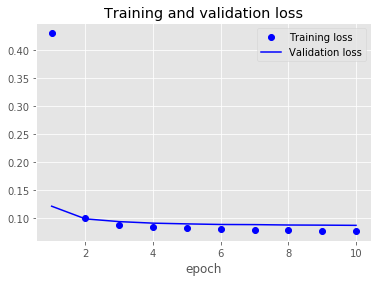

In [82]:
# plot history
plot_training_history(history)

In addition to the final result, we also want to see the intermediate results from hidden layers. Below is an example showing how to get outputs from a hidden layer, and visualize them on the reduced dimension of 2D by PCA. (**Please note that these codes and parameters cannot be simply copied and pasted for other questions; some adjustments need to be made**) 

In [39]:
FFNN=load_keras_model('model_FFNN')

def create_truncated_model_FFNN(trained_model):
    model=Sequential()
    model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
truncated_model = create_truncated_model_FFNN(FFNN)
hidden_features = truncated_model.predict(X_test)

# flatten data
hidden_features=hidden_features.reshape(-1,50)
y_test=y_test.reshape(-1,18)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.9255873871950515


In [40]:
# visualize hidden featurs on first two PCA components
# this plot only shows B-tags
def visualize_hidden_features(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_test, axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        #length=min(1000,len(indices_B))
        #indices_B=indices_B[:length]
        ax.scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat],alpha=0.5)
        legend=ax.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    plt.show()

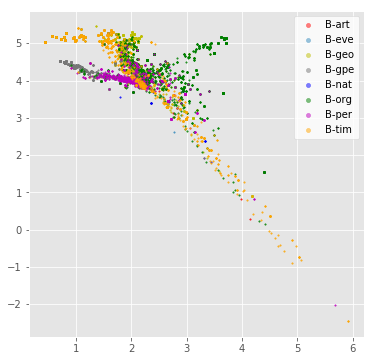

In [41]:
visualize_hidden_features(pca_result)

### Model 3: RNN ###
<span class='sub-q'>**Question 2.3**</span>

(1) Set up a simple RNN model by stacking the following layers in sequence:
* an input layer
* a simple Embedding layer transforming integer words into vectors 
* a dropout layer to regularize the model
* a SimpleRNN layer 
* a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag

(2) Compile the model

(3) Train the model and plot the training history

(4) Visualize outputs from SimpleRNN layer, one subplot for **B-tags** and one subplot for **I-tags**,comment on the patterns you observed.

For hyperparameters use those provided in Model 2

<div class='explication'> </div>

### Solution 2.3 (1) & (2)

In [42]:
# your code #

# Define model
model=Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(SimpleRNN(dim_embed, return_sequences=True))
model.add(TimeDistributed(Dense(n_tags, activation='softmax'), input_shape=(dim_embed, n_tags)))


#  compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_3 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 104, 50)           5050      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           918       
Total params: 1,764,918
Trainable params: 1,764,918
Non-trainable params: 0
_________________________________________________________________
None


### Solution 2.3 (3)

In [150]:
# Training
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
 1088/38846 [..............................] - ETA: 1:28 - loss: 1.3496 - acc: 0.6547

KeyboardInterrupt: 

In [56]:
# save your mode ##
store_keras_model(model, 'model_RNN')

Saved model to disk


In [57]:
# run this cell to show your results #
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_3 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 104, 50)           5050      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           918       
Total params: 1,764,918
Trainable params: 1,764,918
Non-trainable params: 0
_________________________________________________________________
None


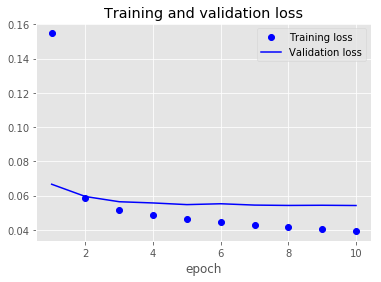

In [58]:
# run this cell to show your results #
plot_training_history(history)

### Solution 2.3 (4)

In [43]:
# define functions
def create_truncated_model(trained_model, hidden_layer):
    model=Sequential()
    model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(Dropout(drop_rate))
    model.add(hidden_layer)
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

def visualize_hidden_features(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_test, axis=1)
    fig, ax = plt.subplots(1, 2, figsize=(15,7))    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        indices_I = np.where(category==cat+8)[0]
        #length=min(1000,len(indices_B))
        #indices_B=indices_B[:length]
        ax[0].scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],
                      s=2,color=color[cat],alpha=0.5)
        ax[0].legend(markerscale=3).get_frame().set_facecolor('w')
        ax[1].scatter(pca_result[indices_I,0], pca_result[indices_I, 1], label=idx2tag[cat+8],
                      s=2,color=color[cat],alpha=0.5)
        ax[1].legend(markerscale=3).get_frame().set_facecolor('w')
    plt.show()

In [44]:
# get hidden features
RNN = load_keras_model('model_RNN')
H = SimpleRNN(dim_embed, return_sequences=True)
truncated_model = create_truncated_model(trained_model=RNN, hidden_layer=H)
hidden_features = truncated_model.predict(X_test)

# flatten data
hidden_features=hidden_features.reshape(-1,50)
y_test=y_test.reshape(-1,18)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.830288621307812


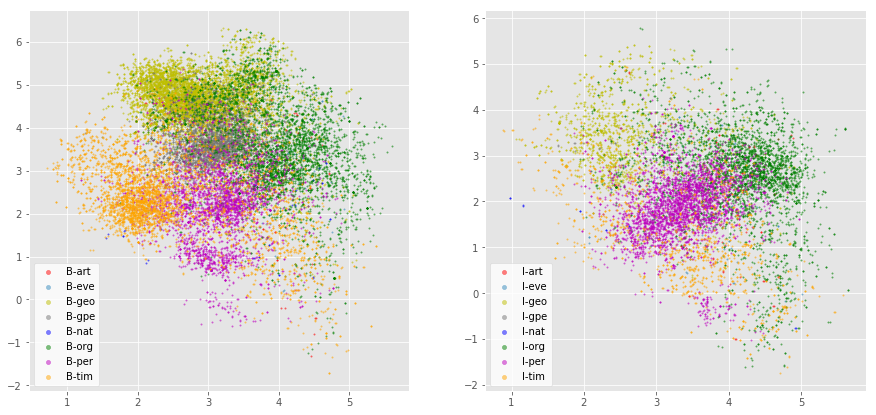

In [45]:
# visualization of hidden features
visualize_hidden_features(pca_result)

<div class='explication'> </div>

### Model 4: GRU ###

<span class='sub-q'>**Question 2.4**</span>


(1) Briefly explain what is GRU and how it is different from simple RNN

(2) build a GRU architecture by replacing the SimpleRNN cell with a GRU one. 

(3) Compile the model

(4) Train the model and plot the training history

(5) Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**, comment on the patterns you observed.

<div class='explication'> </div>

### Solution 2.4 (1)

Reference: https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be

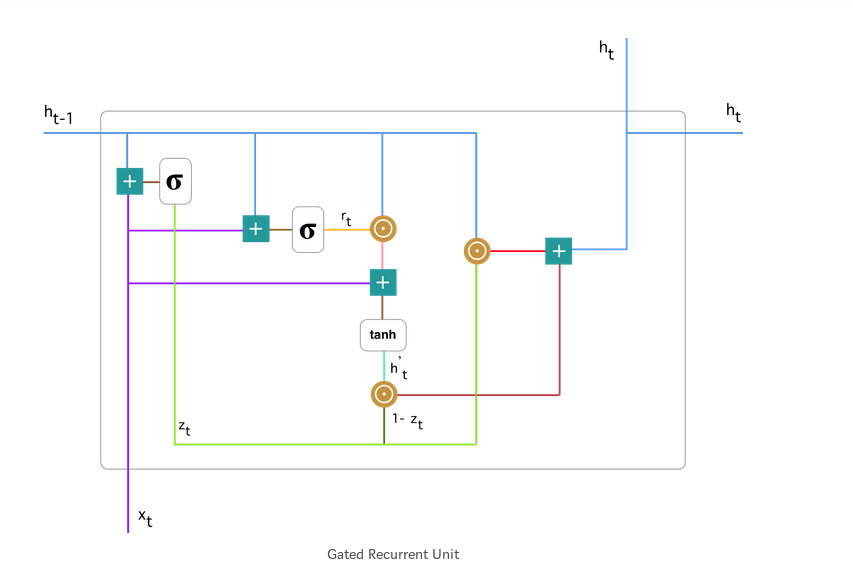

Definitions:
1. $z_t = \sigma(W_z([h_{t-1},x_{t}]))$
2. $r_t = \sigma(W_r([h_{t-1},x_{t}]))$
3. $h'_t = \tanh(W([r_t*h_{t-1},x_{t}]))$
4. $h_t = (1-z_t)*h_{t-1}+z_t*h'_t$
    
GRUs are a variant of LSTMs but with less number of gates. $z_t$ and $r_t$ are the **update** (keeps track of how much of past information is passed along) and **reset gates**(how of past information is forgotten respectively. These feed into $h'_t$ and $h_t$. Thus, we can see that GRUs can remember just the relevant information from the input text, no matter how old or new it is.

### Solution 2.4 (2) & (3)

In [46]:
# your code #

# Define model
model=Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(GRU(dim_embed, return_sequences=True))
model.add(TimeDistributed(Dense(n_tags, activation='softmax'), input_shape=(dim_embed, n_tags)))

#  model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_5 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 104, 50)           15150     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 104, 18)           918       
Total params: 1,775,018
Trainable params: 1,775,018
Non-trainable params: 0
_________________________________________________________________
None


### Solution 2.4 (4)

In [61]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 134s 3ms/step - loss: 0.1708 - acc: 0.9558 - val_loss: 0.0684 - val_acc: 0.9800
Epoch 2/10
38846/38846 [==============================] - 134s 3ms/step - loss: 0.0589 - acc: 0.9828 - val_loss: 0.0596 - val_acc: 0.9822
Epoch 3/10
38846/38846 [==============================] - 134s 3ms/step - loss: 0.0519 - acc: 0.9848 - val_loss: 0.0579 - val_acc: 0.9826
Epoch 4/10
38846/38846 [==============================] - 134s 3ms/step - loss: 0.0484 - acc: 0.9858 - val_loss: 0.0554 - val_acc: 0.9832
Epoch 5/10
38846/38846 [==============================] - 133s 3ms/step - loss: 0.0461 - acc: 0.9865 - val_loss: 0.0544 - val_acc: 0.9836
Epoch 6/10
38846/38846 [==============================] - 134s 3ms/step - loss: 0.0443 - acc: 0.9870 - val_loss: 0.0543 - val_acc: 0.9834
Epoch 7/10
38846/38846 [==============================] - 134s 3ms/step - loss: 0.0429 - acc: 0.9874 - val_loss: 0.0538 - v

In [62]:
# save your model #
store_keras_model(model, 'model_GRU')

Saved model to disk


In [63]:
# run this cell to show your results #
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_4 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 104, 50)           15150     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 104, 18)           918       
Total params: 1,775,018
Trainable params: 1,775,018
Non-trainable params: 0
_________________________________________________________________
None


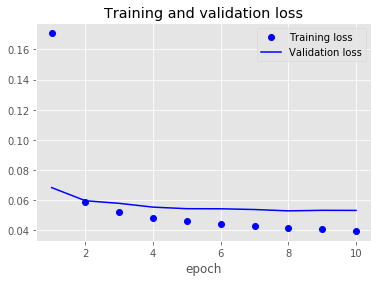

In [64]:
# run this cell to show your results #
plot_training_history(history)

### Solution 2.4 (5)

In [48]:
# get hidden features
GRU = load_keras_model('model_GRU')
H = GRU(dim_embed, input_shape=(max_len, dim_embed), return_sequences=True)
truncated_model = create_truncated_model(trained_model=GRU, hidden_layer=H)
hidden_features = truncated_model.predict(X_test)

# flatten data
hidden_features=hidden_features.reshape(-1,50)
y_test=y_test.reshape(-1,18)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

ValueError: Layer sequential_4 was called with an input that isn't a symbolic tensor. Received type: <class 'int'>. Full input: [50]. All inputs to the layer should be tensors.

In [ ]:
# visualization of hidden features
visualize_hidden_features(pca_result)

<div class='explication'> </div>

### Model 5: Bidirectional GRU ###
<span class='sub-q'>**Question 2.5**</span>


(1) Explain what is Bidirectional GRU and how it is different from GRU model above.

(2) Then build a bidirectional GRU by wrapping your GRU layer into a Bidirectional one

(3) Compile the model

(4) Train the model and plot the training history

(5) Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**, comment on the patterns you observed.

<div class='explication'> </div>

### Solution 2.5 (1)

**Bi-directional GRUs:** The basic idea of the birectional GRUs is to capture the sequence while going in the forward direction as well as backwards. So at each time step, we have RNNs (one going forward and the other backwards) and the input is passed to both of these RNNs. Thus at any given time step, we can capture information from both sides of that step (hence bi-directional).

### Solution 2.5 (2) & (3)

In [66]:
# your code #

# Define model
model=Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(Bidirectional(GRU(dim_embed, return_sequences=True)))
model.add(TimeDistributed(Dense(n_tags, activation='softmax'), input_shape=(dim_embed, n_tags)))

#  model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_5 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 104, 100)          30300     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 104, 18)           1818      
Total params: 1,791,068
Trainable params: 1,791,068
Non-trainable params: 0
_________________________________________________________________
None


### Solution (4)

In [67]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 273s 7ms/step - loss: 0.1406 - acc: 0.9635 - val_loss: 0.0576 - val_acc: 0.9831
Epoch 2/10
38846/38846 [==============================] - 272s 7ms/step - loss: 0.0489 - acc: 0.9857 - val_loss: 0.0492 - val_acc: 0.9853
Epoch 3/10
38846/38846 [==============================] - 275s 7ms/step - loss: 0.0416 - acc: 0.9878 - val_loss: 0.0467 - val_acc: 0.9861
Epoch 4/10
38846/38846 [==============================] - 276s 7ms/step - loss: 0.0382 - acc: 0.9887 - val_loss: 0.0460 - val_acc: 0.9862
Epoch 5/10
38846/38846 [==============================] - 275s 7ms/step - loss: 0.0358 - acc: 0.9894 - val_loss: 0.0451 - val_acc: 0.9865
Epoch 6/10
38846/38846 [==============================] - 270s 7ms/step - loss: 0.0339 - acc: 0.9899 - val_loss: 0.0457 - val_acc: 0.9863
Epoch 7/10
38846/38846 [==============================] - 271s 7ms/step - loss: 0.0323 - acc: 0.9904 - val_loss: 0.0449 - v

In [68]:
# save your model #
store_keras_model(model, 'model_BiGRU')

Saved model to disk


In [69]:
# run this cell to show your results #
model = load_keras_model('model_BiGRU')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_5 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 104, 100)          30300     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 104, 18)           1818      
Total params: 1,791,068
Trainable params: 1,791,068
Non-trainable params: 0
_________________________________________________________________
None


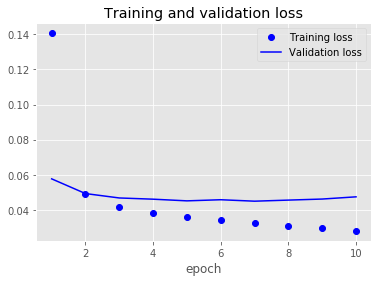

In [70]:
# run this cell to show your results #
plot_training_history(history)

### Solution 2.5 (5)

In [119]:
# get hidden features
BiGRU = load_keras_model('model_BiGRU')
H = Bidirectional(GRU(inputs=dim_embed, return_sequences=True))
truncated_model = create_truncated_model(trained_model=GRU, hidden_layer=H)
hidden_features = truncated_model.predict(X_test)

# flatten data
hidden_features=hidden_features.reshape(-1,50)
y_test=y_test.reshape(-1,18)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

ValueError: Layer sequential_4 was called with an input that isn't a symbolic tensor. Received type: <class 'int'>. Full input: [50]. All inputs to the layer should be tensors.

In [71]:
# visualization of hidden features

<div class='exercise'><b> Question 3: Analysis [40pt]</b></div>


<span class='sub-q'>**Question 3.1**</span>


For each model iteratively:

(1) Load the model using the given function ```load_keras_model```

(2) Apply the model to the test dataset

(3) Compute an F1 score for each ```Tag``` and store it 

(4) Plot the F1 score per Tag and per model making use of a grouped barplot.

(5) Briefly discuss the performance of each model

<span class='sub-q'>**Question 3.2**</span>

(1) Which tags have the lowest f1 score? 

For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="./data/B_art.png" alt="drawing" width="600"/>


(2) Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

In [ ]:
def highlight_errors(s):
    is_max = s == s.y_true
    return ['' if v or key=='Word' else 'color: red' for key,v in is_max.iteritems()]

In [ ]:
# run this cell to show you result #
your_df.style.apply(highlight_errors, axis=1)

<span class='sub-q'>**Question 3.3**</span>

(1) Choose one of the most promising models you have built, improve this model to achieve the f1 score higher than 0.8 for as many tags as possible ( you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, ... )

(2) Explain why you choose to change certain elements of the model and how effective those adjustments are.
